<a href="https://colab.research.google.com/github/lhy332/Streamlit_LangChain/blob/master/20251127_45_0_%7C_30_4_FINAL_w_LOG_%ED%95%A9%EC%84%B1_TQQQ_%EA%B0%80%EA%B2%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3315756268.py:63: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="1999-01-01", end=END_DATE, progress=False)



=== Fortress & Eagle & Bear Hunter (FINAL) ===
Final Equity : $1,537,149
CAGR         : 45.11%
MDD          : -30.43%
Avg MDD      : -7.20%
Total Trades : 750

📅 ACTION PLAN for TODAY (Based on 2025-11-26 Close):
--------------------------------------------------
📊 Market Status: Price=379.05 | MA211=292.04 | VIX=17.19 | RSI=52.02
✅ No Action Required. (Hold Position)
--------------------------------------------------

📝 Recent 10 Trades (Newest First):
      Date  Ticker Side  Amount  Price       Reason  VIX
2025-10-28 Booster SELL  855435    413 Booster Exit 15.8
2025-10-20 Booster  BUY  767892    369   Booster On 20.8
2025-10-17 Booster SELL  746129    362 Booster Exit 25.3
2025-10-13   Eagle  BUY  331292    345  Eagle Start 21.7
2025-09-23 Booster  BUY  774001    372   Booster On 16.1
2025-09-23 Booster SELL  834401    372      Harvest 16.1
2025-06-03 Booster  BUY  569801    253   Booster On 18.4
2025-06-03   Trend  BUY  243143    253     Trend On 18.4
2025-05-29   Trend SELL     

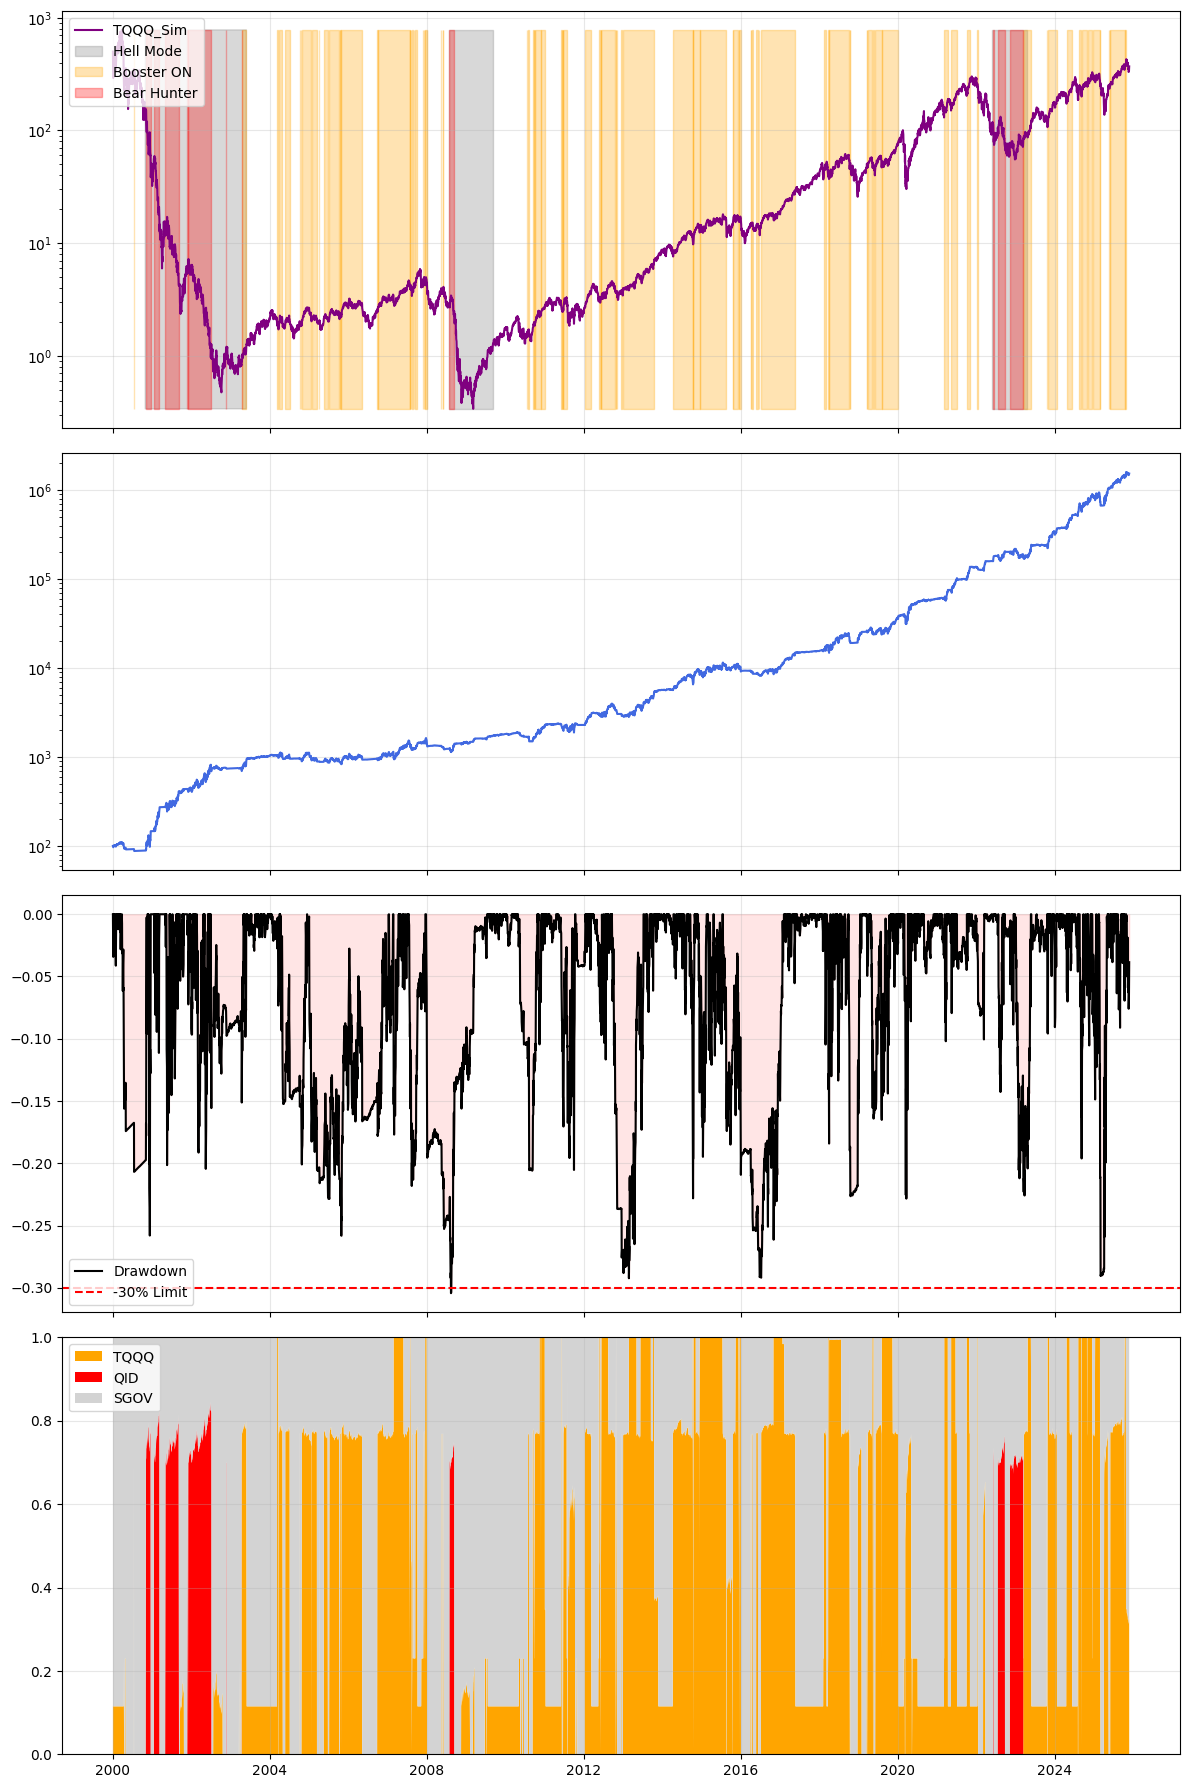

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
# =========================================================
# CONFIG (USER OPTIMIZED FINAL)
# =========================================================
INITIAL_CAPITAL = 100.0

# 1. 자산 배분
TREND_RATIO        = 0.23
BRAKE_TREND_FACTOR = 0.5
BOOSTER_RATIO      = 0.70
EAGLE_RATIO        = 1.00

# 2. 곰 사냥 (Bear Hunter) - QID
HEDGE_RATIO        = 0.70
HEDGE_ENTRY_VIX    = 24.0
HEDGE_EXIT_VIX     = 30.0
HEDGE_RSI_MIN      = 45.0

# 3. 독수리 사냥 (Eagle)
EAGLE_PROFIT_TARGET= 0.30
EAGLE_STOP_LOSS    = 0.31
EAGLE_MDD_COND     = -0.50
EAGLE_VIX_MIN      = 18.0
EAGLE_VIX_MAX      = 24.0
EAGLE_RSI_COND     = 45.0

# 4. 안전장치 & 하베스트
MA_WINDOW          = 211
TREND_MA_ENTRY_BUFFER = 0.00
BRAKE_TRIGGER      = 0.44
BRAKE_RELEASE      = 0.10

HARVEST_RSI_BULL   = 75.0
HARVEST_RSI_BEAR   = 60.0

RISKFREE_ANNUAL    = 0.04
START_DATE         = "2000-01-01"
END_DATE           = datetime.today().strftime('%Y-%m-%d')
# END_DATE           = "2015-11-23"

# 5. 필터
SLOPE_LOOKBACK     = 40
SLOPE_THRESHOLD    = -0.05
VIX_BOOSTER_LIMIT  = 23.0
BOOSTER_SLOPE_FILTER = False

# 6. 스나이퍼
SNIPER_UP_LEVELS    = [-0.20, -0.30, -0.40, -0.50]
SNIPER_UP_WEIGHTS   = [0.40, 0.30, 0.20, 0.10]
SNIPER_DOWN_LEVELS  = [-0.80, -0.99, -0.99, -0.99]
SNIPER_DOWN_WEIGHTS = [0.15, 0.10, 0.10, 0.10]

# =========================================================
# 1. DATA PREPARATION
# =========================================================
def prepare_data():
    print("Downloading Data & Synthesizing...")
    tickers = ["TQQQ", "QQQ", "SHY", "^VIX"]
    data = yf.download(tickers, start="1999-01-01", end=END_DATE, progress=False)

    if isinstance(data.columns, pd.MultiIndex):
        _open = data["Open"].copy()
        _close = data["Close"].copy()
    else:
        raise ValueError("Data Error")

    df = pd.DataFrame()
    df["QQQ_Open"]   = _open.get("QQQ")
    df["QQQ_Close"]  = _close.get("QQQ")
    df["TQQQ_Open"]  = _open.get("TQQQ")
    df["TQQQ_Close"] = _close.get("TQQQ")
    df["VIX"]        = _close.get("^VIX")
    df["SHY_Close"]  = _close.get("SHY")
    df = df.ffill()

    real_tqqq_ret_open  = df["TQQQ_Open"].pct_change().shift(-1)
    synth_tqqq_ret_open = df["QQQ_Open"].pct_change().shift(-1) * 3.0
    df["Ret_Open"]      = real_tqqq_ret_open.combine_first(synth_tqqq_ret_open).fillna(0.0)

    real_tqqq_ret_close  = df["TQQQ_Close"].pct_change().shift(-1)
    synth_tqqq_ret_close = df["QQQ_Close"].pct_change().shift(-1) * 3.0
    df["Ret_Close"]      = real_tqqq_ret_close.combine_first(synth_tqqq_ret_close).fillna(0.0)

    df["QID_Ret_Open"] = (df["QQQ_Open"].pct_change().shift(-1) * -2.0).fillna(0.0)
    daily_rf = (1 + RISKFREE_ANNUAL) ** (1 / 252) - 1
    df["SHY_Ret_Open"] = df["SHY_Close"].pct_change().shift(-1).fillna(daily_rf)

    df["TQQQ_Sim"]  = (1 + df["Ret_Close"].shift(1).fillna(0.0)).cumprod() * 100
    df["MA"]        = df["TQQQ_Sim"].rolling(window=MA_WINDOW).mean()
    df["Disparity"] = (df["TQQQ_Sim"] / df["MA"]) - 1.0

    delta = df["TQQQ_Sim"].diff()
    up, down = delta.clip(lower=0), -1 * delta.clip(upper=0)
    ma_up = up.ewm(com=13, adjust=False).mean()
    ma_down = down.ewm(com=13, adjust=False).mean()
    df["RSI"] = 100 - (100 / (1 + (ma_up / ma_down)))

    df["Slope_Raw"] = (df["MA"] / df["MA"].shift(SLOPE_LOOKBACK)) - 1.0
    df["Slope_Up"]  = df["Slope_Raw"] > SLOPE_THRESHOLD

    df = df.dropna(subset=["MA", "Slope_Up"])
    df = df[df.index >= START_DATE]
    return df

# =========================================================
# 2. BACKTEST ENGINE
# =========================================================
def run_backtest_with_logs(df, hedge_col_name="QID_Ret_Open"):
    dates = df.index
    arr_p = df["TQQQ_Sim"].values; arr_ma = df["MA"].values
    arr_disp = df["Disparity"].values; arr_vix = df["VIX"].values
    arr_rsi = df["RSI"].values; arr_slope = df["Slope_Up"].values
    arr_slope_raw = df["Slope_Raw"].values
    arr_ret = df["Ret_Open"].values; arr_shy = df["SHY_Ret_Open"].values
    arr_hedge_ret = df[hedge_col_name].values

    safe = INITIAL_CAPITAL * (1 - TREND_RATIO)
    trend = INITIAL_CAPITAL * TREND_RATIO
    sniper = 0.0; booster = 0.0; eagle = 0.0; hedge = 0.0

    sniper_mask = [False] * 4
    booster_on = False; trend_on = True; brake_on = False; eagle_on = False

    eagle_entry_price = 0.0; eagle_entry_notional = 0.0
    hedge_entry_notional = 0.0
    sniper_entry_price = [None] * 4

    history = []; trades = []
    peak_equity = INITIAL_CAPITAL

    def log_trade(date, ticker, side, amt, reason, price, vix):
        trades.append({
            "Date": date.date(), "Ticker": ticker, "Side": side,
            "Amount": round(amt), "Price": round(price),
            "Reason": reason, "VIX": round(vix,1)
        })

    for i in range(1, len(df)):
        today = dates[i]
        total_val = safe + trend + sniper + booster + eagle + hedge
        if total_val > peak_equity: peak_equity = total_val
        current_dd = (total_val - peak_equity) / peak_equity

        p = arr_p[i-1]; ma = arr_ma[i-1]; disp = arr_disp[i-1]
        vix = arr_vix[i-1]; rsi = arr_rsi[i-1]; slope = arr_slope[i-1]
        slope_val = arr_slope_raw[i-1]
        sniper_fired = False

        # Brake
        if disp > BRAKE_TRIGGER: brake_on = True
        elif disp < BRAKE_RELEASE: brake_on = False

        # Harvest
        harvest_rsi = HARVEST_RSI_BULL if (p > ma) else HARVEST_RSI_BEAR
        if rsi > harvest_rsi:
            if sniper > 0:
                log_trade(today, "Sniper", "SELL", sniper, "Harvest", p, vix)
                safe += sniper; sniper = 0.0; sniper_mask = [False]*4
            if booster_on:
                log_trade(today, "Booster", "SELL", booster, "Harvest", p, vix)
                safe += booster; booster = 0.0; booster_on = False
            if hedge > 0:
                log_trade(today, "Hedge", "SELL", hedge, "Harvest", p, vix)
                safe += hedge; hedge = 0.0; hedge_entry_notional = 0.0

            target = 0.0
            if trend_on and p > ma:
                ratio = TREND_RATIO * BRAKE_TREND_FACTOR if brake_on else TREND_RATIO
                target = total_val * ratio
            if trend > target:
                diff = trend - target
                trend -= diff; safe += diff

        # Hedge Exit
        if hedge > 0:
            if (vix > HEDGE_EXIT_VIX) or (p > ma):
                log_trade(today, "Hedge", "SELL", hedge, "Exit(VIX/Trend)", p, vix)
                safe += hedge; hedge = 0.0; hedge_entry_notional = 0.0

        # Trend Logic
        if trend_on and p < ma:
            trend_on = False; brake_on = False
            log_trade(today, "Trend", "SELL", trend, "Trend Broken", p, vix)
            safe += trend; trend = 0.0

            if booster_on:
                log_trade(today, "Booster", "SELL", booster, "Trend Broken", p, vix)
                safe += booster; booster = 0.0; booster_on = False
            if eagle_on:
                log_trade(today, "Eagle", "SELL", eagle, "Trend Broken", p, vix)
                safe += eagle; eagle = 0.0; eagle_on = False; eagle_entry_notional = 0.0

            # Hedge Entry
            if (hedge == 0) and (slope_val < SLOPE_THRESHOLD) and \
               (vix < HEDGE_ENTRY_VIX) and (rsi > HEDGE_RSI_MIN):
                invest = safe * HEDGE_RATIO
                if invest > 0:
                    safe -= invest; hedge += invest; hedge_entry_notional = invest
                    log_trade(today, "Hedge", "BUY", invest, "Entry(Hell)", p, vix)

        elif (not trend_on) and p > ma * (1 + TREND_MA_ENTRY_BUFFER):
            trend_on = True
            if hedge > 0:
                log_trade(today, "Hedge", "SELL", hedge, "Trend Restored", p, vix)
                safe += hedge; hedge = 0.0; hedge_entry_notional = 0.0
            if sniper > 0:
                log_trade(today, "Sniper", "SELL", sniper, "Reset", p, vix)
                safe += sniper; sniper = 0.0; sniper_mask = [False]*4
            if eagle > 0:
                log_trade(today, "Eagle", "SELL", eagle, "Reset", p, vix)
                safe += eagle; eagle = 0.0; eagle_on = False; eagle_entry_notional = 0.0

            ratio = TREND_RATIO * BRAKE_TREND_FACTOR if brake_on else TREND_RATIO
            invest = total_val * ratio
            if invest > 0:
                if safe >= invest: safe -= invest; trend += invest
                else: trend += safe; safe = 0.0
                log_trade(today, "Trend", "BUY", invest, "Trend On", p, vix)

        elif trend_on and p > ma:
            ratio = TREND_RATIO * BRAKE_TREND_FACTOR if brake_on else TREND_RATIO
            target = total_val * ratio
            diff = target - trend
            if diff > 0 and safe >= diff:
                trend += diff; safe -= diff
                # Rebalance log 생략 (너무 많음)
            elif diff < 0:
                cut = abs(diff); trend -= cut; safe += cut

        # Hedge Late Entry
        if (not trend_on) and (p < ma) and (hedge == 0):
            if (slope_val < SLOPE_THRESHOLD) and (vix < HEDGE_ENTRY_VIX) and (rsi > HEDGE_RSI_MIN):
                invest = safe * HEDGE_RATIO
                if invest > 0:
                    safe -= invest; hedge += invest; hedge_entry_notional = invest
                    log_trade(today, "Hedge", "BUY", invest, "Late Entry", p, vix)

        # Booster
        if booster_on:
            if vix >= VIX_BOOSTER_LIMIT or p < ma or brake_on:
                log_trade(today, "Booster", "SELL", booster, "Booster Exit", p, vix)
                safe += booster; booster = 0.0; booster_on = False
        else:
            boost_cond = (vix < VIX_BOOSTER_LIMIT) and (p > ma) and (not brake_on) and (sum(sniper_mask) == 0)
            if BOOSTER_SLOPE_FILTER: boost_cond = boost_cond and (slope_val > 0)

            if boost_cond:
                total_liquid = safe + eagle
                target_invest = total_liquid * BOOSTER_RATIO
                if target_invest > 0:
                    if safe < target_invest:
                        needed = target_invest - safe
                        take = min(eagle, needed)
                        eagle -= take; safe += take
                        if eagle <= 0: eagle_on = False
                    safe -= target_invest; booster += target_invest; booster_on = True
                    log_trade(today, "Booster", "BUY", target_invest, "Booster On", p, vix)

        # Eagle
        if eagle_on:
            if p >= eagle_entry_price * (1 + EAGLE_PROFIT_TARGET):
                log_trade(today, "Eagle", "SELL", eagle, "Eagle TP", p, vix)
                safe += eagle; eagle = 0.0; eagle_on = False
            elif p <= eagle_entry_price * (1 - EAGLE_STOP_LOSS):
                log_trade(today, "Eagle", "SELL", eagle, "Eagle SL", p, vix)
                safe += eagle; eagle = 0.0; eagle_on = False
        else:
            if (current_dd > EAGLE_MDD_COND) and (p > ma) and \
               (vix >= EAGLE_VIX_MIN) and (vix < EAGLE_VIX_MAX) and \
               (rsi < EAGLE_RSI_COND) and (sum(sniper_mask) == 0) and (not brake_on):
                invest = safe * EAGLE_RATIO
                if invest > 0:
                    safe -= invest; eagle += invest; eagle_on = True
                    eagle_entry_price = p; eagle_entry_notional = invest
                    log_trade(today, "Eagle", "BUY", invest, "Eagle Start", p, vix)

        # Sniper
        if vix >= 35:
            for idx, level in enumerate(SNIPER_UP_LEVELS if slope else SNIPER_DOWN_LEVELS):
                if disp <= level and not sniper_mask[idx]:
                    w = (SNIPER_UP_WEIGHTS if slope else SNIPER_DOWN_WEIGHTS)[idx]
                    buy_amt = safe * w
                    if buy_amt > 0:
                        safe -= buy_amt; sniper += buy_amt; sniper_mask[idx] = True; sniper_fired = True
                        log_trade(today, "Sniper", "BUY", buy_amt, f"L{idx+1}", p, vix)

        # --- [FIX: Add missing keys to history] ---
        history.append({
            "Date": today,
            "Equity": total_val,
            "Price_TQQQ_Sim": p,
            "Safe_SGOV": safe,
            "Risk_TQQQ": trend + sniper + booster + eagle,
            "Hedge_QID": hedge,
            "BoosterOn": booster_on,
            "EagleOn": eagle_on,    # <--- Added
            "SniperFired": sniper_fired,
            "VIX": vix,             # <--- Added
            "RSI": rsi,             # <--- Added
            "Disparity": disp,      # <--- Added
            "MA": ma,               # <--- Added
            "BrakeOn": brake_on,    # <--- Added
            "Slope_Raw": slope_val,
            "HedgeActive": hedge > 0
        })

        t_r = arr_ret[i]; s_r = arr_shy[i]; h_r = arr_hedge_ret[i]
        trend *= (1+t_r); sniper *= (1+t_r); booster *= (1+t_r); eagle *= (1+t_r)
        hedge *= (1+h_r); safe *= (1+s_r)

    return pd.DataFrame(history).set_index("Date"), pd.DataFrame(trades)

# =========================================================
# 3. REPORT & PLOTS
# =========================================================
# =========================================================
# 3. REPORT & PLOTS (Real-time Data Fix)
# =========================================================
def make_full_report(df, hedge_col_name="QID_Ret_Open"):
    # 1. 백테스트 실행 (과거 성과 분석용)
    hist, trades = run_backtest_with_logs(df, hedge_col_name)

    equity = hist["Equity"]
    peak = equity.cummax()
    dd = (equity - peak) / peak

    final_eq = equity.iloc[-1]
    cagr = (final_eq / INITIAL_CAPITAL) ** (1 / ((equity.index[-1] - equity.index[0]).days / 365.25)) - 1
    mdd = dd.min()
    avg_mdd = dd.mean()

    print(f"\n=== Fortress & Eagle & Bear Hunter (FINAL) ===")
    print(f"Final Equity : ${final_eq:,.0f}")
    print(f"CAGR         : {cagr*100:.2f}%")
    print(f"MDD          : {mdd*100:.2f}%")
    print(f"Avg MDD      : {avg_mdd*100:.2f}%")
    print(f"Total Trades : {len(trades)}")

    # ---------------------------------------------------------
    # [FIX] 오늘 아침 행동 지침 (원본 데이터 df 참조)
    # ---------------------------------------------------------
    # hist(백테스트 결과) 대신 df(원본 데이터)의 마지막 줄을 가져와야
    # '어제 종가' 기준의 최신 데이터를 볼 수 있음.

    latest_data = df.iloc[-1] # 11월 25일 데이터
    current_date = df.index[-1].date() # 2025-11-25

    # 최신 시장 지표 (어제 종가)
    last_price = latest_data['TQQQ_Sim']
    last_ma    = latest_data['MA']
    last_vix   = latest_data['VIX']
    last_rsi   = latest_data['RSI']
    last_slope = latest_data['Slope_Raw']
    last_disp  = latest_data['Disparity']

    # 내 포지션 상태는 시뮬레이션 결과(hist)의 마지막 상태를 참조
    # (어제 장 마감 후 내가 뭘 들고 있었는지)
    last_port = hist.iloc[-1]
    is_trend_on   = (last_port['Risk_TQQQ'] > 0)
    is_booster_on = last_port['BoosterOn']
    is_eagle_on   = last_port['EagleOn']
    is_hedge_on   = (last_port['Hedge_QID'] > 0)

    # Brake 상태 (어제 종가 이격도 기준 재계산)
    is_brake_on = False
    if last_disp > BRAKE_TRIGGER: is_brake_on = True
    elif last_disp < BRAKE_RELEASE: is_brake_on = False # (보수적 접근: 해제 조건은 시뮬레이션 상태 따라야 하나 여기선 단순화)
    # 정확히 하려면 hist의 brake 상태를 가져오되, 오늘 아침 갱신된 이격도 반영이 필요.
    # 여기서는 hist의 마지막 상태를 유지하되, Trigger만 체크.
    if last_port['BrakeOn'] and (last_disp > BRAKE_RELEASE):
        is_brake_on = True # 브레이크 유지

    # 현재 계좌 MDD (시뮬레이션 상)
    current_sim_mdd = (last_port['Equity'] - peak.iloc[-1]) / peak.iloc[-1]

    print(f"\n📅 ACTION PLAN for TODAY (Based on {current_date} Close):")
    print("-" * 50)
    print(f"📊 Market Status: Price={last_price:.2f} | MA{MA_WINDOW}={last_ma:.2f} | VIX={last_vix:.2f} | RSI={last_rsi:.2f}")

    actions = []

    # --- Action Logic (df 데이터 기반 재판단) ---

    # 1. Trend Logic
    if is_trend_on:
        if last_price < last_ma:
            actions.append("🚨 SELL ALL TQQQ (Trend Broken)")
            if is_booster_on: actions.append("🚨 SELL BOOSTER")
            if is_eagle_on: actions.append("🚨 SELL EAGLE")

            # Hedge Entry
            if (not is_hedge_on) and (last_slope < SLOPE_THRESHOLD) and \
               (last_vix < HEDGE_ENTRY_VIX) and (last_rsi > HEDGE_RSI_MIN):
                actions.append(f"🐻 BUY HEDGE ({HEDGE_RATIO*100}% of Safe)")
    else:
        if last_price > last_ma:
            actions.append("✅ BUY TQQQ (Trend Restored)")
            if is_hedge_on: actions.append("✅ SELL HEDGE (QID)")
        else:
            # Hedge Late Entry
            if (not is_hedge_on) and (last_slope < SLOPE_THRESHOLD) and \
               (last_vix < HEDGE_ENTRY_VIX) and (last_rsi > HEDGE_RSI_MIN):
                actions.append(f"🐻 BUY HEDGE ({HEDGE_RATIO*100}% of Safe)")

    # 2. Hedge Exit
    if is_hedge_on:
        if last_vix > HEDGE_EXIT_VIX:
            actions.append("💰 SELL HEDGE (VIX Panic)")

    # 3. Booster Logic
    boost_cond = (last_vix < VIX_BOOSTER_LIMIT) and (last_price > last_ma) and (not is_brake_on)
    if BOOSTER_SLOPE_FILTER: boost_cond = boost_cond and (last_slope > 0)

    harvest_rsi = HARVEST_RSI_BULL if (last_price > last_ma) else HARVEST_RSI_BEAR

    if is_booster_on:
        if not boost_cond:
            actions.append("🔻 SELL BOOSTER (Condition Lost)")
        if last_rsi > harvest_rsi:
            actions.append(f"💰 HARVEST BOOSTER (RSI {last_rsi:.1f})")
    else:
        # Sniper 활동 중 아닐 때 (간략 체크 VIX < 35)
        if boost_cond and (last_vix < 35):
            actions.append(f"🚀 BUY BOOSTER - Safe의 {BOOSTER_RATIO*100}% 추가 투입")

    # 4. Eagle Logic
    if is_eagle_on:
        if last_rsi > harvest_rsi:
            actions.append(f"💰 SELL EAGLE (RSI Harvest)")
        # TP/SL은 장중 가격이라 여기선 체크 불가, 보유 중이면 홀딩 메시지
    else:
        mdd_ok = current_sim_mdd > EAGLE_MDD_COND
        mkt_ok = (last_price > last_ma) and (last_vix >= EAGLE_VIX_MIN) and \
                 (last_vix < EAGLE_VIX_MAX) and (last_rsi < EAGLE_RSI_COND) and (not is_brake_on)

        if mdd_ok and mkt_ok and (last_vix < 35):
            actions.append(f"🦅 BUY EAGLE - 남은 Safe의 {EAGLE_RATIO*100}% 투입")

    # 5. Harvest (General)
    if last_rsi > harvest_rsi:
         if is_hedge_on: actions.append(f"💰 HARVEST HEDGE (RSI {last_rsi:.1f})")

    if actions:
        for action in actions:
            print(action)
    else:
        print("✅ No Action Required. (Hold Position)")

    print("-" * 50)

    trades.to_csv("fortress_trade_log_qid.csv", index=False)
    print("\n📝 Recent 10 Trades (Newest First):")
    if not trades.empty:
        print(trades.iloc[::-1].head(30).to_string(index=False))
    else:
        print("No trades found.")

    # Graphs
    comp = pd.DataFrame(index=hist.index)
    comp["TQQQ"] = hist["Risk_TQQQ"] / hist["Equity"]
    comp["QID"]  = hist["Hedge_QID"] / hist["Equity"]
    comp["SGOV"] = hist["Safe_SGOV"] / hist["Equity"]

    price = hist["Price_TQQQ_Sim"]
    hell_mode = hist["Slope_Raw"] < SLOPE_THRESHOLD

    fig, axes = plt.subplots(4, 1, figsize=(12, 18), sharex=True)

    axes[0].plot(price, label="TQQQ_Sim", color="purple")
    axes[0].fill_between(hist.index, price.min(), price.max(), where=hell_mode,
                    color='gray', alpha=0.3, label='Hell Mode')
    axes[0].fill_between(hist.index, price.min(), price.max(), where=hist["BoosterOn"],
                    color='orange', alpha=0.3, label='Booster ON')
    axes[0].fill_between(hist.index, price.min(), price.max(), where=hist["HedgeActive"],
                    color='red', alpha=0.3, label='Bear Hunter')
    axes[0].set_yscale("log"); axes[0].legend(loc='upper left'); axes[0].grid(True, alpha=0.3)

    axes[1].plot(equity, label="Strategy Equity", color="royalblue")
    axes[1].set_yscale("log"); axes[1].grid(True, alpha=0.3)

    axes[2].plot(dd, label="Drawdown", color="black")
    axes[2].fill_between(dd.index, dd, 0, color="red", alpha=0.1)
    axes[2].axhline(-0.3, color="red", linestyle="--", label="-30% Limit")
    axes[2].legend(); axes[2].grid(True, alpha=0.3)

    axes[3].stackplot(comp.index, comp["TQQQ"], comp["QID"], comp["SGOV"],
                 labels=["TQQQ", "QID", "SGOV"], colors=["orange", "red", "lightgray"])
    axes[3].set_ylim(0, 1); axes[3].legend(loc="upper left"); axes[3].grid(True, alpha=0.3)

    plt.tight_layout(); plt.show()

    return hist, trades

if __name__ == "__main__":
    df = prepare_data()
    hist, trades = make_full_report(df, hedge_col_name="QID_Ret_Open")

In [ ]:
//@version=5
indicator("TQQQ Fortress & Eagle (Final Standard)", overlay=true)

// =============================================================================
// 1. 사용자 설정 (Inputs)
// =============================================================================
grp_capital = "💰 자산 설정"
total_equity = input.float(90000, "내 총 자산 ($/CAD)", group=grp_capital, tooltip="현재 계좌의 총 평가금액을 입력하세요.")

grp_param = "자산 배분 (헌법)"
trend_ratio   = input.float(0.23, "Trend 비중 (기본 23%)", group=grp_param)
booster_ratio = input.float(0.50, "Booster 비중 (Safe의 50%)", group=grp_param)
eagle_ratio   = input.float(1.00, "Eagle 비중 (남은 Safe의 100%)", group=grp_param)

grp_risk   = "안전장치 & 필터"
ma_len        = input.int(210, "장기 추세선 (210일)", group=grp_risk)
brake_trig    = input.float(0.44, "Brake 발동 (이격도 0.44)", group=grp_risk)
brake_rel     = input.float(0.10, "Brake 해제 (이격도 0.10)", group=grp_risk)
vix_booster_limit = input.float(23.0, "Booster VIX 한계 (23)", group=grp_risk)

grp_eagle  = "🦅 독수리 사냥 (Eagle Shot)"
eagle_vix_min = input.float(18.0, "Eagle VIX 최소 (18)", group=grp_eagle)
eagle_vix_max = input.float(24.0, "Eagle VIX 최대 (24)", group=grp_eagle)
eagle_rsi_cond= input.float(45.0, "Eagle RSI 조건 (45 이하)", group=grp_eagle)
eagle_tp      = input.float(0.30, "익절 목표 (+30%)", group=grp_eagle)
eagle_sl      = input.float(0.30, "손절 한계 (-30%)", group=grp_eagle)
eagle_mdd_cond= input.float(-0.10, "진입 허용 MDD (-10%)", group=grp_eagle)

// Sniper 설정 (간략화)
grp_sniper = "Sniper"
// ... (스나이퍼 로직은 복잡성을 줄이기 위해 Disparity 기준으로 간략히 표시)

// =============================================================================
// 2. 데이터 계산 (어제 종가 기준)
// =============================================================================
// VIX (일봉 데이터)
vix = request.security("CBOE:VIX", "D", close[1])

// MA 210
ma_long_raw = ta.sma(close, ma_len)
ma_long = ma_long_raw[1] // 어제 값

// Price & Disparity
price_yesterday = close[1]
disparity = (price_yesterday / ma_long) - 1

// RSI
rsi = ta.rsi(close, 14)[1]

// =============================================================================
// 3. 상태 관리 (State Logic)
// =============================================================================

// [Brake]
var bool is_brake_on = false
if disparity > brake_trig
    is_brake_on := true
else if disparity < brake_rel
    is_brake_on := false

// [MDD 시뮬레이션] (간이 계산: 실제 계좌 연동 불가하므로 가격 기반 추정)
// 여기서는 사용자가 입력한 자산 기준으로 시뮬레이션할 수 없으므로,
// TQQQ 가격의 고점 대비 하락률(Drawdown)을 대용 지표로 사용합니다.
// (내 계좌가 시장과 비슷하게 움직인다고 가정)
var float peak_price = 0.0
if price_yesterday > peak_price
    peak_price := price_yesterday
float market_dd = (price_yesterday - peak_price) / peak_price

// [Booster]
bool cond_booster_enter = (vix < vix_booster_limit) and (price_yesterday > ma_long) and (not is_brake_on)
bool cond_booster_exit  = (vix >= vix_booster_limit) or (price_yesterday < ma_long) or is_brake_on

var bool booster_active = false
if booster_active
    if cond_booster_exit
        booster_active := false
else
    if cond_booster_enter
        booster_active := true

// [Eagle Shot]
var bool eagle_active = false
var float eagle_entry_price = 0.0

// Eagle 진입 조건
bool cond_eagle_enter = (market_dd > eagle_mdd_cond) and (price_yesterday > ma_long) and (vix >= eagle_vix_min) and (vix < eagle_vix_max) and (rsi < eagle_rsi_cond) and (not is_brake_on)

// Eagle 청산 조건 (TP/SL)
bool cond_eagle_win  = eagle_active and (price_yesterday >= eagle_entry_price * (1 + eagle_tp))
bool cond_eagle_loss = eagle_active and (price_yesterday <= eagle_entry_price * (1 - eagle_sl))
// Eagle 강제 청산 (Trend 붕괴)
bool cond_eagle_die  = eagle_active and (price_yesterday < ma_long)

if eagle_active
    if cond_eagle_win or cond_eagle_loss or cond_eagle_die
        eagle_active := false
        eagle_entry_price := 0.0
else
    // 부스터가 꺼져 있거나, 켜져 있어도 자금이 남으면 진입 가능 (여기선 단순화하여 조건 만족 시 진입)
    if cond_eagle_enter
        eagle_active := true
        eagle_entry_price := price_yesterday

// =============================================================================
// 4. 자산 배분 계산 (Target Calculation)
// =============================================================================
// 1. Trend
float val_trend = 0.0
if price_yesterday > ma_long
    float ratio = is_brake_on ? (trend_ratio * 0.5) : trend_ratio
    val_trend := total_equity * ratio

// 2. Booster
float val_booster = 0.0
float safe_after_trend = total_equity - val_trend

// 부스터 우선권 (Booster First)
if booster_active
    val_booster := safe_after_trend * booster_ratio

// 3. Eagle
float val_eagle = 0.0
float safe_after_booster = safe_after_trend - val_booster

if eagle_active
    val_eagle := safe_after_booster * eagle_ratio // 남은 돈의 100%

// 4. Sniper (간략화: 지옥 모드만 체크)
float val_sniper = 0.0
// (Pine Script 한계상 복잡한 Sniper 로직은 생략하고, 주요 레벨만 텍스트로 안내)

float final_tqqq = val_trend + val_booster + val_eagle
float final_cash = total_equity - final_tqqq
float tqqq_pct   = (final_tqqq / total_equity) * 100

// =============================================================================
// 5. 시각화 (Visuals)
// =============================================================================
// MA Plot
plot(ma_long_raw, "MA 210", color = close > ma_long_raw ? color.green : color.red, linewidth = 2)

// Eagle 진입/청산 표시
plotshape(eagle_active and not eagle_active[1], "Eagle Buy", shape.labelup, location.belowbar, color.lime, text="Eagle\nBuy", textcolor=color.black)
plotshape(cond_eagle_win, "Eagle Win", shape.labeldown, location.abovebar, color.blue, text="Eagle\nWin!", textcolor=color.white)
plotshape(cond_eagle_die, "Eagle Die", shape.labeldown, location.abovebar, color.orange, text="Eagle\nCut", textcolor=color.white)

// 대시보드
var table dash = table.new(position.top_right, 2, 8, border_width = 1, frame_color = color.gray)

if barstate.islast
    // Header
    table.cell(dash, 0, 0, "Fortress & Eagle", bgcolor=color.navy, text_color=color.white)
    table.cell(dash, 1, 0, "상태 현황", bgcolor=color.navy, text_color=color.white)

    // 1. Trend Status
    string t_txt = price_yesterday > ma_long ? (is_brake_on ? "⚠️과열 (Brake)" : "✅상승 (Trend On)") : "🛡️방어 (Trend Off)"
    color t_col = price_yesterday > ma_long ? (is_brake_on ? color.orange : color.green) : color.red
    table.cell(dash, 0, 1, "Trend", bgcolor=color.black, text_color=color.white)
    table.cell(dash, 1, 1, t_txt, bgcolor=t_col, text_color=color.white)

    // 2. Booster Status
    string b_txt = booster_active ? "🚀ON (50%)" : "OFF"
    table.cell(dash, 0, 2, "Booster", bgcolor=color.black, text_color=color.white)
    table.cell(dash, 1, 2, b_txt, bgcolor=booster_active ? color.blue : color.gray, text_color=color.white)

    // 3. Eagle Status
    string e_txt = eagle_active ? "🦅Hunting" : (cond_eagle_enter ? "Go!" : "Waiting")
    if eagle_active
        e_txt += "\nEntry: " + str.tostring(math.round(eagle_entry_price))
    table.cell(dash, 0, 3, "Eagle", bgcolor=color.black, text_color=color.white)
    table.cell(dash, 1, 3, e_txt, bgcolor=eagle_active ? color.lime : color.gray, text_color=eagle_active ? color.black : color.white)

    // 4. Target Amount
    table.cell(dash, 0, 4, "TQQQ 목표금액", bgcolor=color.white, text_color=color.black)
    table.cell(dash, 1, 4, "$" + str.tostring(math.round(final_tqqq)), bgcolor=color.yellow, text_color=color.black, text_size=size.large)

    // 소수점 둘째 자리까지 표시 (11.5 -> 11.50)
    table.cell(dash, 0, 5, "목표 비중", bgcolor=color.white, text_color=color.black)
    table.cell(dash, 1, 5, str.tostring(tqqq_pct, "#.##") + "%", bgcolor=color.yellow, text_color=color.black)

    // 6. Current VIX
    table.cell(dash, 0, 6, "VIX (전일)", bgcolor=color.black, text_color=color.white)
    table.cell(dash, 1, 6, str.tostring(vix), bgcolor=vix >= 24 ? color.red : (vix >= 18 ? color.green : color.gray), text_color=color.white)

// Alerts
alertcondition(eagle_active and not eagle_active[1], "Eagle Launch", "독수리 사냥 시작! 남은 현금 투입")
alertcondition(cond_eagle_win, "Eagle Profit", "독수리 익절 달성 (+30%)")
alertcondition(price_yesterday < ma_long and price_yesterday[1] > ma_long[1], "Trend Broken", "210선 붕괴! 전원 대피")

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None

import yfinance as yf
import numpy as np
import smtplib
from email.mime.text import MIMEText
from datetime import datetime, timedelta
import pytz
import os

# =========================================================
# 0. 환경 변수
# =========================================================
EMAIL_SENDER = os.environ.get("EMAIL_USER")
EMAIL_PASSWORD = os.environ.get("EMAIL_PASS")
EMAIL_RECEIVER = os.environ.get("EMAIL_TO")
INITIAL_CAPITAL = float(os.environ.get("MY_SEED_MONEY", 145))

# [설정]
tz_ny = pytz.timezone('America/New_York')
now_ny = datetime.now(tz_ny)
START_DATE = "2010-01-01"
END_DATE = (now_ny + timedelta(days=1)).strftime('%Y-%m-%d')
ANALYSIS_START_DATE = "2011-01-01"

# =========================================================
# 1. CONFIG
# =========================================================
TREND_RATIO        = 0.23
BRAKE_TREND_FACTOR = 0.5
BOOSTER_RATIO      = 0.70
EAGLE_RATIO        = 1.00

HEDGE_RATIO        = 0.70
HEDGE_ENTRY_VIX    = 24.0
HEDGE_EXIT_VIX     = 30.0
HEDGE_RSI_MIN      = 45.0

EAGLE_PROFIT_TARGET= 0.30
EAGLE_STOP_LOSS    = 0.31
EAGLE_VIX_MIN      = 18.0
EAGLE_VIX_MAX      = 24.0
EAGLE_RSI_COND     = 45.0

MA_WINDOW          = 211
BRAKE_TRIGGER      = 0.44
BRAKE_RELEASE      = 0.10
HARVEST_RSI_BULL   = 75.0
HARVEST_RSI_BEAR   = 60.0
RISKFREE_ANNUAL    = 0.04

SLOPE_LOOKBACK     = 40
SLOPE_THRESHOLD    = -0.05
VIX_BOOSTER_LIMIT  = 23.0
BOOSTER_SLOPE_FILTER = False

SNIPER_UP_LEVELS    = [-0.20, -0.30, -0.40, -0.50]
SNIPER_UP_WEIGHTS   = [0.40, 0.30, 0.20, 0.10]
SNIPER_DOWN_LEVELS  = [-0.80, -0.99, -0.99, -0.99]
SNIPER_DOWN_WEIGHTS = [0.15, 0.10, 0.10, 0.10]

# =========================================================
# 2. DATA PREPARATION (Fixed)
# =========================================================
def prepare_data():
    print(f"Downloading Data ({START_DATE} ~ {END_DATE})...")
    tickers = ["TQQQ", "QID", "SHY", "^VIX"]

    try:
        data = yf.download(tickers, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True, threads=False)
    except Exception as e:
        raise ValueError(f"yfinance Download Error: {e}")

    if data.empty: raise ValueError("❌ 데이터 다운로드 실패")

    if isinstance(data.columns, pd.MultiIndex):
        try:
            if 'Close' in data.columns.levels[0]: _close = data['Close'].copy()
            elif 'Adj Close' in data.columns.levels[0]: _close = data['Adj Close'].copy()
            else: _close = data.xs('Close', axis=1, level=1)

            if 'Open' in data.columns.levels[0]: _open = data['Open'].copy()
            else: _open = _close.copy()
        except Exception as e:
            _close = data.xs('Close', axis=1, level=1) if 'Close' in data.columns.levels[1] else data
            _open = data.xs('Open', axis=1, level=1) if 'Open' in data.columns.levels[1] else _close
    else:
        _close = data['Close'].copy(); _open = data['Open'].copy()

    df = pd.DataFrame()
    try:
        df["TQQQ_Open"]  = _open["TQQQ"]; df["TQQQ_Close"] = _close["TQQQ"]
        df["QID_Open"]   = _open["QID"];  df["QID_Close"]  = _close["QID"]

        if "^VIX" in _close.columns:
            df["VIX"] = _close["^VIX"]
            df["VIX_Open"] = _open["^VIX"]
        elif "VIX" in _close.columns:
            df["VIX"] = _close["VIX"]
            df["VIX_Open"] = _open["VIX"]
        else: raise KeyError("VIX Missing")

        df["SHY_Close"]  = _close["SHY"]
    except KeyError as e:
        raise ValueError(f"❌ 필수 티커 누락: {e}")

    df = df.ffill().dropna()

    # 수익률 (Open to Open)
    df["Ret_Open"] = df["TQQQ_Open"].pct_change(fill_method=None).shift(-1).fillna(0.0)
    df["QID_Ret_Open"] = df["QID_Open"].pct_change(fill_method=None).shift(-1).fillna(0.0)

    daily_rf = (1 + RISKFREE_ANNUAL) ** (1 / 252) - 1
    df["SHY_Ret_Open"] = df["SHY_Close"].pct_change(fill_method=None).shift(-1).fillna(daily_rf)

    # [수정됨] Ret_Close 계산 없이 바로 실제 가격 사용
    df["Price"] = df["TQQQ_Close"]

    # 백테스트 엔진 호환성을 위해 TQQQ_Sim도 실제 가격으로 매핑
    df["TQQQ_Sim"] = df["Price"]

    # Indicators
    df["MA"] = df["Price"].rolling(window=MA_WINDOW).mean()
    df["Disparity"] = (df["Price"] / df["MA"]) - 1.0

    # Wilder's RSI
    delta = df["Price"].diff()
    up, down = delta.clip(lower=0), -1 * delta.clip(upper=0)
    ma_up = up.ewm(com=13, adjust=False).mean()
    ma_down = down.ewm(com=13, adjust=False).mean()
    df["RSI"] = 100 - (100 / (1 + (ma_up / ma_down)))

    # Slope
    df["Slope_Raw"] = (df["MA"] / df["MA"].shift(SLOPE_LOOKBACK)) - 1.0
    df["Slope_Up"]  = df["Slope_Raw"] > SLOPE_THRESHOLD

    # Real Price for Report
    df["Real_Price"] = df["Price"]
    df["Real_MA"]    = df["MA"]

    df = df.dropna(subset=["MA", "Slope_Up"])
    df = df[df.index >= ANALYSIS_START_DATE]

    print(f"✅ Data Ready: {df.index[0].date()} ~ {df.index[-1].date()} ({len(df)} rows)")
    return df

# =========================================================
# 3. BACKTEST ENGINE
# =========================================================
def run_backtest_logic(df):
    dates = df.index
    arr_p = df["TQQQ_Sim"].values; arr_ma = df["MA"].values
    arr_disp = df["Disparity"].values;


    arr_vix = df["VIX"].values

    arr_rsi = df["RSI"].values; arr_slope = df["Slope_Up"].values
    arr_slope_raw = df["Slope_Raw"].values

    arr_ret = df["Ret_Open"].values
    arr_shy = df["SHY_Ret_Open"].values
    arr_hedge_ret = df["QID_Ret_Open"].values

    safe = INITIAL_CAPITAL * (1 - TREND_RATIO)
    trend = INITIAL_CAPITAL * TREND_RATIO
    sniper = 0.0; booster = 0.0; eagle = 0.0; hedge = 0.0

    sniper_mask = [False] * 4
    booster_on = False; trend_on = True; brake_on = False; eagle_on = False
    eagle_entry_price = 0.0; hedge_entry_notional = 0.0; sniper_entry_price = [None]*4

    history = []; trades = []
    peak_equity = INITIAL_CAPITAL

    def log_trade(date, ticker, side, amt, reason, price, vix):
        trades.append({
            "Date": date.date(), "Ticker": ticker, "Side": side,
            "Amount": round(amt), "Price": round(price, 2),
            "Reason": reason, "VIX": round(vix,1)
        })

    loop_len = len(df)

    for i in range(loop_len):
        today = dates[i]
        total_val = safe + trend + sniper + booster + eagle + hedge
        if total_val > peak_equity: peak_equity = total_val
        current_dd = (total_val - peak_equity) / peak_equity

        if i == 0:
            history.append({
                "Date": today, "Equity": total_val, "Price_Sim": arr_p[i],
                "Risk_TQQQ": trend, "Hedge_QID": hedge, "Safe_SGOV": safe,
                "BoosterOn": False, "EagleOn": False, "HedgeOn": False, "BrakeOn": False,
                "Slope_Raw": 0.0
            })
            continue

        p = arr_p[i-1]; ma = arr_ma[i-1]; disp = arr_disp[i-1]
        rsi = arr_rsi[i-1]; slope = arr_slope[i-1]; slope_val = arr_slope_raw[i-1]

        vix = arr_vix[i-1]

        sniper_fired = False

        # --- LOGIC ---
        if disp > BRAKE_TRIGGER: brake_on = True
        elif disp < BRAKE_RELEASE: brake_on = False

        harvest_rsi = HARVEST_RSI_BULL if (p > ma) else HARVEST_RSI_BEAR
        if rsi > harvest_rsi:
            if sniper > 0:
                log_trade(today, "Sniper", "SELL", sniper, "Harvest", p, vix)
                safe += sniper; sniper = 0.0; sniper_mask = [False]*4
            if booster_on:
                log_trade(today, "Booster", "SELL", booster, "Harvest", p, vix)
                safe += booster; booster = 0.0; booster_on = False
            if hedge > 0:
                log_trade(today, "Hedge", "SELL", hedge, "Harvest", p, vix)
                safe += hedge; hedge = 0.0; hedge_entry_notional = 0.0

            target = 0.0
            if trend_on and p > ma:
                ratio = TREND_RATIO * BRAKE_TREND_FACTOR if brake_on else TREND_RATIO
                target = total_val * ratio
            if trend > target:
                diff = trend - target
                trend -= diff; safe += diff

        if hedge > 0:
            if (vix > HEDGE_EXIT_VIX) or (p > ma):
                log_trade(today, "Hedge", "SELL", hedge, "Exit(VIX/Trend)", p, vix)
                safe += hedge; hedge = 0.0; hedge_entry_notional = 0.0

        if trend_on and p < ma:
            trend_on = False; brake_on = False
            log_trade(today, "Trend", "SELL", trend, "Trend Broken", p, vix)
            safe += trend; trend = 0.0
            if booster_on:
                log_trade(today, "Booster", "SELL", booster, "Trend Broken", p, vix)
                safe += booster; booster = 0.0; booster_on = False
            if eagle_on:
                log_trade(today, "Eagle", "SELL", eagle, "Trend Broken", p, vix)
                safe += eagle; eagle = 0.0; eagle_on = False

            if (hedge == 0) and (slope_val < SLOPE_THRESHOLD) and \
               (vix < HEDGE_ENTRY_VIX) and (rsi > HEDGE_RSI_MIN):
                invest = safe * HEDGE_RATIO
                if invest > 0:
                    safe -= invest; hedge += invest; hedge_entry_notional = invest
                    log_trade(today, "Hedge", "BUY", invest, "Entry(Hell)", p, vix)
        elif (not trend_on) and p > ma:
            trend_on = True
            if hedge > 0:
                log_trade(today, "Hedge", "SELL", hedge, "Trend Restored", p, vix)
                safe += hedge; hedge = 0.0; hedge_entry_notional = 0.0
            if sniper > 0:
                log_trade(today, "Sniper", "SELL", sniper, "Reset", p, vix)
                safe += sniper; sniper = 0.0; sniper_mask = [False]*4
            if eagle > 0:
                log_trade(today, "Eagle", "SELL", eagle, "Reset", p, vix)
                safe += eagle; eagle = 0.0; eagle_on = False

            ratio = TREND_RATIO * BRAKE_TREND_FACTOR if brake_on else TREND_RATIO
            invest = total_val * ratio
            if invest > 0:
                if safe >= invest: safe -= invest; trend += invest
                else: trend += safe; safe = 0.0
                log_trade(today, "Trend", "BUY", invest, "Trend On", p, vix)
        elif trend_on and p > ma:
            ratio = TREND_RATIO * BRAKE_TREND_FACTOR if brake_on else TREND_RATIO
            target = total_val * ratio
            diff = target - trend
            if diff > 0 and safe >= diff: trend += diff; safe -= diff
            elif diff < 0: trend -= abs(diff); safe += abs(diff)

        if (not trend_on) and (p < ma) and (hedge == 0):
            if (slope_val < SLOPE_THRESHOLD) and (vix < HEDGE_ENTRY_VIX) and (rsi > HEDGE_RSI_MIN):
                invest = safe * HEDGE_RATIO
                if invest > 0:
                    safe -= invest; hedge += invest; hedge_entry_notional = invest
                    log_trade(today, "Hedge", "BUY", invest, "Late Entry", p, vix)

        if booster_on:
            if vix >= VIX_BOOSTER_LIMIT or p < ma or brake_on:
                log_trade(today, "Booster", "SELL", booster, "Booster Exit", p, vix)
                safe += booster; booster = 0.0; booster_on = False
        else:
            boost_cond = (vix < VIX_BOOSTER_LIMIT) and (p > ma) and (not brake_on) and (sum(sniper_mask) == 0)
            if BOOSTER_SLOPE_FILTER: boost_cond = boost_cond and (slope_val > 0)
            if boost_cond:
                total_liquid = safe + eagle
                target_invest = total_liquid * BOOSTER_RATIO
                if target_invest > 0:
                    if safe < target_invest:
                        needed = target_invest - safe
                        take = min(eagle, needed)
                        eagle -= take; safe += take
                        if eagle <= 0: eagle_on = False
                    safe -= target_invest; booster += target_invest; booster_on = True
                    log_trade(today, "Booster", "BUY", target_invest, "Booster On", p, vix)

        if eagle_on:
            if p >= eagle_entry_price * (1 + EAGLE_PROFIT_TARGET):
                log_trade(today, "Eagle", "SELL", eagle, "Eagle TP", p, vix)
                safe += eagle; eagle = 0.0; eagle_on = False
            elif p <= eagle_entry_price * (1 - EAGLE_STOP_LOSS):
                log_trade(today, "Eagle", "SELL", eagle, "Eagle SL", p, vix)
                safe += eagle; eagle = 0.0; eagle_on = False
        else:
            if (p > ma) and \
               (vix >= EAGLE_VIX_MIN) and (vix < EAGLE_VIX_MAX) and \
               (rsi < EAGLE_RSI_COND) and (sum(sniper_mask) == 0) and (not brake_on):
                invest = safe * EAGLE_RATIO
                if invest > 0:
                    safe -= invest; eagle += invest; eagle_on = True
                    eagle_entry_price = p; eagle_entry_notional = invest
                    log_trade(today, "Eagle", "BUY", invest, "Eagle Start", p, vix)

        if vix >= 35:
            for idx, level in enumerate(SNIPER_UP_LEVELS if slope else SNIPER_DOWN_LEVELS):
                if disp <= level and not sniper_mask[idx]:
                    w = (SNIPER_UP_WEIGHTS if slope else SNIPER_DOWN_WEIGHTS)[idx]
                    buy_amt = safe * w
                    if buy_amt > 0:
                        safe -= buy_amt; sniper += buy_amt; sniper_mask[idx] = True; sniper_fired = True
                        log_trade(today, "Sniper", "BUY", buy_amt, f"L{idx+1}", p, vix)

        history.append({
            "Date": today, "Equity": total_val, "Price_Sim": p,
            "Risk_TQQQ": trend + sniper + booster + eagle,
            "Hedge_QID": hedge, "Safe_SGOV": safe,
            "BoosterOn": booster_on, "EagleOn": eagle_on, "HedgeOn": hedge > 0, "BrakeOn": brake_on,
            "Slope_Raw": slope_val
        })

        if i < loop_len - 1:
            t_r = arr_ret[i]; s_r = arr_shy[i]; h_r = arr_hedge_ret[i]
            trend *= (1+t_r); sniper *= (1+t_r); booster *= (1+t_r); eagle *= (1+t_r)
            hedge *= (1+h_r); safe *= (1+s_r)

    return pd.DataFrame(history).set_index("Date"), pd.DataFrame(trades)

# =========================================================
# 4. REPORT GENERATOR
# =========================================================
def get_action_plan_text(df):
    today_date = datetime.today().date()
    if df.index[-1].date() >= today_date:
        df_analysis = df.iloc[:-1].copy()
    else:
        df_analysis = df.copy()

    hist, trades = run_backtest_logic(df_analysis)

    last_row = hist.iloc[-1]
    last_date = hist.index[-1].date()

    latest_data = df_analysis.iloc[-1]
    real_price = latest_data['Real_Price']
    real_ma    = latest_data['Real_MA']
    vix   = latest_data['VIX']
    rsi   = latest_data['RSI']
    slope = latest_data['Slope_Raw']

    is_trend_on   = (last_row['Risk_TQQQ'] > 0)
    is_booster_on = last_row['BoosterOn']
    is_eagle_on   = bool(last_row.get('EagleOn', False))
    is_hedge_on   = bool(last_row.get('HedgeOn', False))
    is_brake_on   = bool(last_row.get('BrakeOn', False))

    total_eq = last_row['Equity']
    pct_tqqq = (last_row['Risk_TQQQ'] / total_eq) * 100
    pct_qid  = (last_row['Hedge_QID'] / total_eq) * 100
    pct_safe = (last_row['Safe_SGOV'] / total_eq) * 100

    report = f"""
[Fortress & Eagle] Daily Briefing
====================================
기준일: {last_date} (Close)
실행일: {datetime.today().strftime('%Y-%m-%d')} (Open)

📊 Real Market Status
---------------------
• Price : ${real_price:.2f} (MA{MA_WINDOW}: ${real_ma:.2f})
• Trend : {"📈 UP" if real_price > real_ma else "🔻 DOWN"} (Slope: {slope*100:.2f}%)
• VIX   : {vix:.2f}
• RSI   : {rsi:.2f}

🛡️ Portfolio Target (Today)
---------------------------
• TQQQ : {pct_tqqq:.1f}%
• QID  : {pct_qid:.1f}%
• CASH : {pct_safe:.1f}%

📋 TODAY'S ACTION
====================================
"""
    actions = []

    if is_trend_on:
        if real_price < real_ma:
            actions.append("🚨 [매도] 211선 붕괴! TQQQ 전량 매도")
            if (not is_hedge_on) and (slope < SLOPE_THRESHOLD) and \
               (vix < HEDGE_ENTRY_VIX) and (rsi > HEDGE_RSI_MIN):
                actions.append(f"🐻 [매수] 곰 사냥 시작 (QID) - Safe {HEDGE_RATIO*100}%")
    else:
        if real_price > real_ma:
            actions.append(f"✅ [매수] 211선 회복! TQQQ Trend 진입")
            if is_hedge_on: actions.append("✅ [매도] 곰 사냥 종료")
        else:
             if (not is_hedge_on) and (slope < SLOPE_THRESHOLD) and \
                (vix < HEDGE_ENTRY_VIX) and (rsi > HEDGE_RSI_MIN):
                 actions.append(f"🐻 [매수] 곰 사냥 추가 진입 (QID)")

    if is_hedge_on:
        if vix > HEDGE_EXIT_VIX: actions.append(f"💰 [매도] QID 익절 (VIX {vix:.1f})")

    boost_cond = (vix < VIX_BOOSTER_LIMIT) and (real_price > real_ma) and (not is_brake_on)
    if BOOSTER_SLOPE_FILTER: boost_cond = boost_cond and (slope > 0)
    harvest_rsi = HARVEST_RSI_BULL if (real_price > real_ma) else HARVEST_RSI_BEAR

    if is_booster_on:
        if not boost_cond: actions.append("🔻 [매도] 부스터 청산")
        if rsi > harvest_rsi: actions.append(f"💰 [매도] 부스터 하베스트 (RSI {rsi:.1f})")
    else:
        if boost_cond and (vix < 35): actions.append(f"🚀 [매수] 부스터 가동! - Safe {BOOSTER_RATIO*100}%")

    if is_eagle_on:
        if rsi > harvest_rsi: actions.append(f"💰 [매도] 독수리 하베스트 (RSI {rsi:.1f})")
    else:
        mkt_ok = (real_price > real_ma) and (vix >= EAGLE_VIX_MIN) and \
                 (vix < EAGLE_VIX_MAX) and (rsi < EAGLE_RSI_COND) and (not is_brake_on)
        if mkt_ok and (vix < 35) and (not is_booster_on):
             actions.append(f"🦅 [매수] 독수리 출격! - 남은 Safe {EAGLE_RATIO*100}%")

    if rsi > harvest_rsi:
        if is_hedge_on: actions.append(f"💰 [매도] QID 하베스트 (RSI {rsi:.1f})")

    if vix >= 35 and real_price < real_ma:
        d = (real_price / real_ma) - 1
        lvls = SNIPER_UP_LEVELS if slope > 0 else SNIPER_DOWN_LEVELS
        m_name = "눌림목" if slope > 0 else "지옥"
        for lvl in lvls:
             if d <= lvl + 0.005:
                 actions.append(f"🎯 [매수] 스나이퍼 ({m_name}) 진입/대기 (이격도 {d*100:.1f}%)")
                 break

    if not actions:
        report += "✅ No Action. (Hold Position)\n"
    else:
        for act in actions: report += f"{act}\n"

    report += "\n" + "-" * 50 + "\n"

    trades.to_csv("fortress_trade_log_qid.csv", index=False)
    print("\n📝 Recent 10 Trades (Newest First):")
    if not trades.empty:
        report += trades.iloc[::-1].head(10).to_string(index=False)
    else:
        report += "No trades found."

    return report

# =========================================================
# 5. SEND EMAIL
# =========================================================
def send_email(subject, body):
    if not EMAIL_SENDER or not EMAIL_PASSWORD:
        print("⚠️ 이메일 설정 없음. 화면 출력:\n")
        print(body)
        return
    msg = MIMEText(body)
    msg['Subject'] = subject
    msg['From'] = EMAIL_SENDER
    msg['To'] = EMAIL_RECEIVER
    try:
        with smtplib.SMTP_SSL('smtp.gmail.com', 465) as server:
            server.login(EMAIL_SENDER, EMAIL_PASSWORD)
            server.send_message(msg)
        print(f"📧 이메일 발송 성공!")
    except Exception as e:
        print(f"❌ 이메일 발송 실패: {e}")

if __name__ == "__main__":
    try:
        df = prepare_data()
        report = get_action_plan_text(df)
        today_str = datetime.today().strftime('%Y-%m-%d')
        subj = f"🚨 [ACTION] {today_str}" if "매수" in report or "매도" in report else f"✅ [HOLD] {today_str}"
        send_email(subj + " Fortress Report", report)
    except Exception as e:
        print(f"Error: {e}")